# Fancier example of transform

So you have thought of maybe interpolating your ocean data to a different [depth grid](https://xgcm.readthedocs.io/en/latest/transform.html#Depth-to-Depth) or - the classic - interpolating onto [temperature/density layers](https://xgcm.readthedocs.io/en/latest/transform.html#Depth-to-Potential-Temperature) with [`xgcm.Grid.transform`](https://xgcm.readthedocs.io/en/latest/transform.html#). But these are only a few options. 

Lets go through a bit different example here: Transforming the data to a modified depth coordinate system based on a time variable diagnostic, like the mixed layer depth. 

> This can also be applied to other diagnostics, like e.g. the euphotic zone depth or others

First lets get some processing resources...

In [1]:
from dask_gateway import GatewayCluster
from distributed import Client

cluster = GatewayCluster()
cluster.scale(6)
client = Client(cluster)
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.3ce28fbaceb34c899fed82899861e5dc Dashboard: /services/dask-gateway/clusters/staging.3ce28fbaceb34c899fed82899861e5dc/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Then load GFDL's high resolution climate model CM2.6 as an example:

In [2]:
from intake import open_catalog
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
ds

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/coding/times.py:517: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


<xarray.Dataset>
Dimensions:            (nv: 2, st_edges_ocean: 51, st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50, time: 240, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates: (12/14)
    geolat_c           (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_c           (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * nv                 (nv) float64 1.0 2.0
  * st_edges_ocean     (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
    ...                 ...
  * sw_ocean           (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * time               (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean           (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * xu_ocean           (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.9 80.0
  * yt_ocean           (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * yu_ocean           (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.96 90.0
Data variables: (12/31)
    average_DT         (time) timedelta64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_T1         (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2         (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    eta_t              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    eta_u              (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    frazil_2d          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ...                 ...
    temp_rivermix      (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    time_bounds        (time, nv) timedelta64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    ty_trans           (time, st_ocean, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    u                  (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    v                  (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    wt                 (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      CM2.6_miniBling

This dataset is massive! Since we want to regrid in the vertical we have to get rid of the chunking along the depth dimension (`st_ocean`).
> For smaller datasets this is likely not necessary. The way it is done below might also not be super efficient, and for transforming large datasets you should consider [rechunker](https://rechunker.readthedocs.io/en/latest/).

In [6]:
# rechunk the data in depth 
ds = ds.chunk({'xt_ocean':360, 'xu_ocean':360, 'st_ocean':-1})

In [7]:
temp = ds.temp
mld = ds.mld
z = ds.st_ocean # not 100% accurate (I could show how to transform this...)

The trick here is to define a new depth array that gives us the difference to the mixed layer depth at every time and grid position

In [8]:
# There is an issue with the resulting chunksize from xarray broadcasting,
# this leads to 10GB chunks
# z_relative = z - mld

# so lets just do it with this trick
z_broadcasted = xr.ones_like(temp) * z
z_relative = z_broadcasted - mld 
z_relative

<xarray.DataArray (time: 240, st_ocean: 50, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<sub, shape=(240, 50, 2700, 3600), dtype=float64, chunksize=(1, 50, 2700, 360), chunktype=numpy.ndarray>
Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 360), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 360), meta=np.ndarray>
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

Ok this was easy, but what have we done? We basically have created a new 4D dataarray which instead of the fixed depth now has variables depth values that show the depth relative to the mixed layer.
Lets illustrate this on an example profile:

In [9]:
roi = {'xt_ocean':2000, 'yt_ocean':1000, 'st_ocean':slice(0,20), 'time':slice(0,12*5)}

temp_profile = temp.isel(**roi).load()
z_profile = z.isel(**roi, missing_dims='ignore').load()
z_relative_profile = z_relative.isel(**roi).load()
mld_profile = mld.isel(**roi, missing_dims='ignore').load()

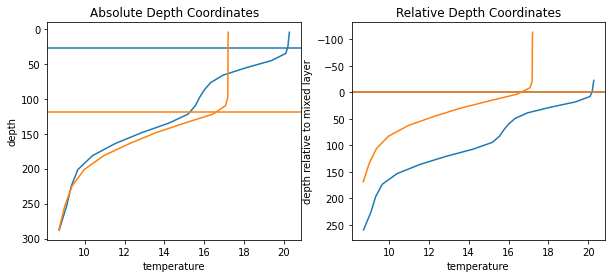

In [10]:
plt.figure(figsize=[10,4])

for tt, color in zip([0,6], ['C0', 'C1']):
    plt.subplot(1,2,1)
    plt.plot(temp_profile.isel(time=tt), z_profile, color=color)
    plt.axhline(mld_profile.isel(time=tt), color=color)
    plt.ylabel('depth')
    plt.xlabel('temperature')
    plt.title('Absolute Depth Coordinates')
    plt.subplot(1,2,2)
    plt.plot(temp_profile.isel(time=tt), z_relative_profile.isel(time=tt), color=color)
    plt.axhline(0, color=color)
    plt.ylabel('depth relative to mixed layer')
    plt.xlabel('temperature')
    plt.title('Relative Depth Coordinates')
    
for ai in range(2):
    plt.subplot(1,2,ai+1)
    plt.gca().invert_yaxis()


You can see the seasonal deepening/shallowing of the mixed layer in the left panel. On the right panel, the values right at the mixed-layer boundary are aligned, and the values above and below are 'streched'. The deepening of the mixed layer is now shown with the orange line extending further into the negative numbers (meaning above the mixed layer depth).

We can now use this new coordinate to transform the whole dataset very efficiently with xgcm:

In [11]:
from xgcm import Grid
import numpy as np

grid = Grid(ds, periodic=False, coords={'Z':{'center':'st_ocean'}})

# create the values to interpolate to (these are m depth relative to the mixed layer)
target_raw = np.arange(-100, 300, 20)
target = xr.DataArray(target_raw, dims=['depth_relative_to_ml'], coords={'depth_relative_to_ml':target_raw})
temp_on_z_relative = grid.transform(temp, 'Z', target , target_data=z_relative)

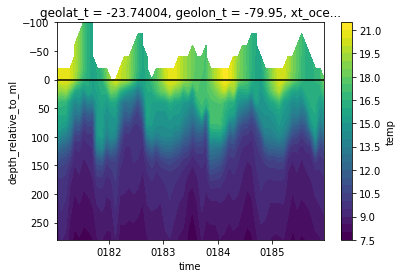

In [12]:
temp_on_z_relative.isel(**roi, missing_dims='ignore').plot.contourf(levels=30, x='time', yincrease=False)
plt.axhline(0, color='k')

This example plot shows the time evolution of temperature relative to the mixed layer (black line). You can clearly see how the temperature values from the 'high' winter mixed layer are subducted into the interior while the mixed layer warms and shallows during the summer.